In [2]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import glob
import lmfit
from scipy.ndimage import gaussian_filter1d

parent_parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_parent_dir)
import scresonators.src as scres

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm

%reload_ext autoreload

In [3]:
# # from src.dcm import DCM
# # from src.fitter import Fitter
# cur_dir = os.getcwd()
# print(cur_dir)
# parent_parent_dir = os.path.dirname(os.path.dirname(cur_dir))
# sys.path.append(parent_parent_dir)
# import scresonators as scres

# # Mocking Fitter.find_circle to return predefined values for the test
# # Fitter.find_circle = staticmethod(lambda x, y: (0.5, 0.5, 1.0))

# # def dcm_instance():
# #     return scres.src.fit_methods.dcm.DCM()

# # dcm1 = dcm_instance() #instantiated the dcm class
# # #arguments of func: (x, Q, Qc, w1, phi)
# # dcm1_func = dcm1.func()

# func = 1 - Q / Qc * np.exp(1j * phi) / (1 + 1j * (x - w1) / w1 * 2 * Q)

In [4]:
def simulate_data(Q, Qc, phi, w1, num_points, freq_range):
    """
    Generates simulated data for the given function as a function of frequency x.

    Args:
        Q (float): Quality factor.
        Qc (float): Coupling quality factor.
        phi (float): Phase angle in radians.
        w1 (float): Resonant frequency.
        num_points (int): Number of points in the frequency range. Default is 100.
        freq_range (tuple): Frequency range as (min_freq, max_freq). Default is (0, 10).

    Returns:
        freqs (np.ndarray): Array of frequency values.
        data (np.ndarray): Array of complex data values for each frequency.
    """
    # Generate frequency values
    freqs = np.linspace(freq_range[0], freq_range[1], num_points)
    
    # Calculate the complex data values
    data = 1 - Q / Qc * np.exp(1j * phi) / (1 + 1j * (freqs - w1) / w1 * 2 * Q)
    
    return freqs, data

# Plotting function
# Custom formatter function to ensure each tick label has the actual frequency (not just 0.00050, 0.00055, etc with +4.512 on the lower right side)
def custom_formatter(x, pos):
    return f'{x:.5f}'


def _estimate_initial_parameters(f_data, phase):
        """Estimate initial parameters for the fitting process.
        
        Args: 
            f_data (np.ndarray): array of frequency data (Hz), an array of floats
            phase (np.ndarray): phase data (radians), an array of floats

        Returns:
            fr_guess (float): guess of resonant frequency (Hz)
            Ql_guess (float): guess of loaded quality factor 
            delay_guess (float): guess of cable time delay (s) ## not sure about this...
        """
        phase_smooth = gaussian_filter1d(phase, 30) ## should we unwrap phases first or is that redundant?
        fr_guess = f_data[np.argmax(np.gradient(phase_smooth))] 
        Ql_guess = 2 * fr_guess / (f_data[-1] - f_data[0])
        delay_guess = -(np.ptp(phase) / (2 * np.pi * (f_data[-1] - f_data[0])))
        return  fr_guess, Ql_guess, delay_guess

In [5]:
Q = 1e5
Qc = 1e5
phi = 0.2
w1 = 5e9
num_points = 50
freq_range = (4.998e9, 5.002e9)

freqs, data = simulate_data(Q, Qc, phi, w1, num_points, freq_range)
amps_linear = np.abs(data)
amps = 20*np.log10(amps_linear)
phases = np.angle(data)
cmplx = amps*np.exp(1j*phases)

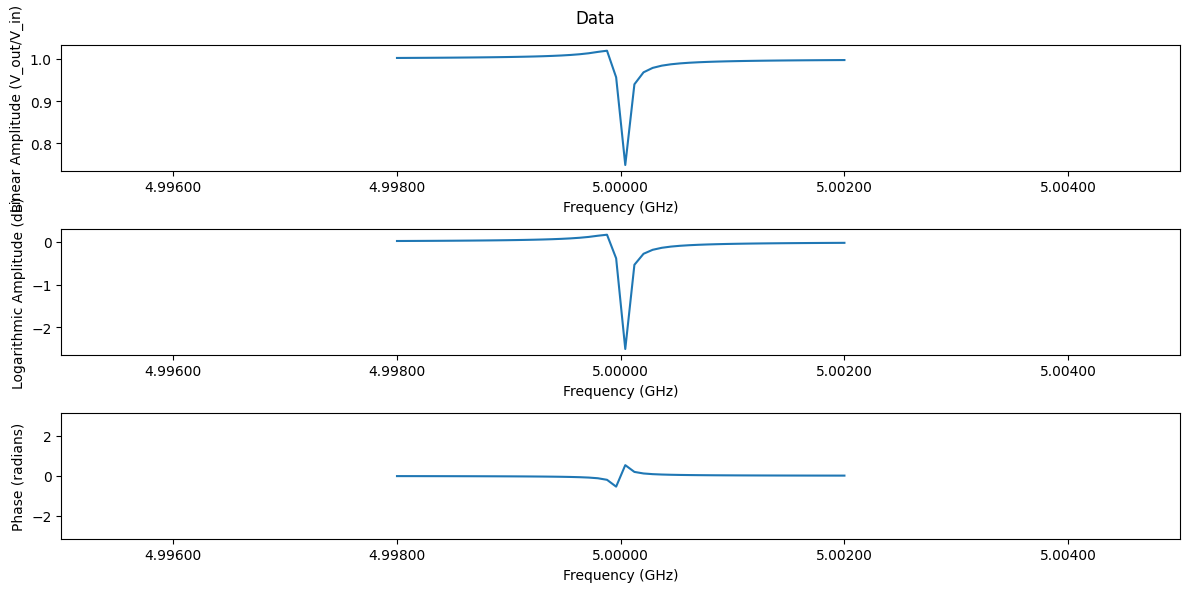

In [27]:
plt.figure(figsize=(12, 6))

xlim_min = 4.995
xlim_max = 5.005

plt.subplot(3,1,1)
plt.plot(freqs/1e9, amps_linear)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Linear Amplitude (V_out/V_in)')
plt.xlim(xlim_min, xlim_max)
# plt.ylim(0,10)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter)) # Set the formatter for the x-axis

plt.subplot(3,1,2)
plt.plot(freqs/1e9, amps)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Logarithmic Amplitude (dB)')
plt.xlim(xlim_min, xlim_max)
# plt.ylim(0,10)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter)) # Set the formatter for the x-axis

plt.subplot(3,1,3)
plt.plot(freqs/1e9, phases)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Phase (radians)')
plt.xlim(xlim_min, xlim_max)
plt.ylim(-np.pi, np.pi)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter)) # Set the formatter for the x-axis

plt.suptitle('Data')
plt.tight_layout()
plt.show()

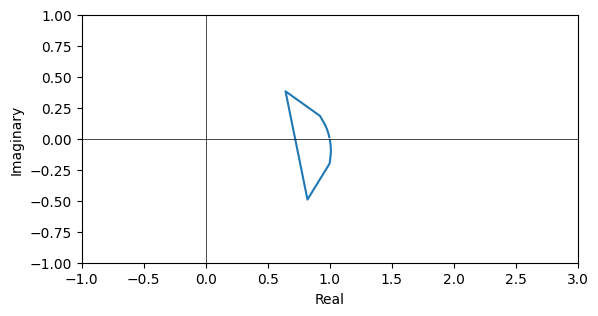

In [7]:
# Plot the real and imaginary parts of the data

plt.plot(data.real, data.imag)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.xlim(-1,3)
plt.ylim(-1,1)
plt.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.5)  # Add vertical line at x=0
plt.gca().set_aspect('equal', adjustable='box') # Set aspect of the plot to be equal


### Try to fit to the simulated data with initial guesses and save data to csv files

In [25]:
dcm_method = scres.fit_methods.dcm.DCM() ## Making an instance of DCM class. 
FitRes = scres.Fitter(dcm_method) ## Making instance of Fitter class.
## if I wanted to use kwargs: FitRes = scres.Fitter(dcm_method, preprocess='linear')

w1_guess, _, _ = _estimate_initial_parameters(freqs, phases)
init_guess = {
    'Q' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e4, 'min' : 1e3, 'max' : 1e9},
    'w1' : {'value' : w1_guess, 'min' : w1_guess-3e3, 'max' : w1_guess+3e3, 'vary' : True},
    'phi' : {'value' : 1.266, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_guess_df = pd.DataFrame(init_guess)
print(init_guess_df)

    # def separate_columns(df):
    #     column_number = df.shape[1]
    #     # list1 = list(range(column_number))
    #     # for i in range(column_number):

labels_guess_array = np.array(['value', 'min', 'max', 'vary'])
Q_guess_array = init_guess_df['Q'].to_numpy()
Qc_guess_array = init_guess_df['Qc'].to_numpy()
w1_guess_array = init_guess_df['w1'].to_numpy()
phi_guess_array = init_guess_df['phi'].to_numpy()

init_params = lmfit.create_params(**init_guess)
init_params.pretty_print()

result, conf_intervals = FitRes.fit(freqs, amps, phases, manual_init=init_params, verbose=True) ## set verbose=True if you want extra outputs

fit_result_params = result.params

labels_results_array = np.array(['value', 'stderr'])
Q_result_array = np.array([fit_result_params['Q'].value, fit_result_params['Q'].stderr])
Qc_result_array = np.array([fit_result_params['Qc'].value, fit_result_params['Qc'].stderr])
w1_result_array = np.array([fit_result_params['w1'].value, fit_result_params['w1'].stderr])
phi_result_array = np.array([fit_result_params['phi'].value, fit_result_params['phi'].stderr])

# Log ('save', not 'logarithmic') fitted data, initial guesses, and data into a csv file
# First begin by making two separate dataframes
data_s21 = {
    'Frequency (Hz)': freqs,
    'Amplitude (dB)': amps,
    'Phase (radians)': phases
}
df_s21 = pd.DataFrame(data_s21)

data_guesses = {
    'Initial Guesses Table': labels_guess_array,
    'Q': Q_guess_array,
    'Qc': Qc_guess_array,
    'w1 (Hz)': w1_guess_array,
    'phi (radians)': phi_guess_array
}
df_guesses = pd.DataFrame(data_guesses)

data_results = {
    'Parameter Results Table': labels_results_array,
    'Q': Q_result_array,
    'Qc': Qc_result_array,
    'w1 (Hz)': w1_result_array,
    'phi (radians)': phi_result_array
}
df_results = pd.DataFrame(data_results)

# Concatenate the dataframes
df_concatenated1 = pd.concat([df_s21, df_guesses], axis=1)
df_concatenated2 = pd.concat([df_concatenated1, df_results], axis=1)

print("Concatenated dataframe:\n", df_concatenated2)

# Save the DataFrame to a CSV file
csv_name = 'dcm_1'
csv_path = f'simulated_data/{csv_name}.csv'
df_concatenated2.to_csv(csv_path, index=False)

                  Q            Qc                w1       phi
value  1.000000e+05  1.000000e+04  5000040816.32653  1.266000
min    1.000000e+03  1.000000e+03  5000037816.32653 -1.570796
max    1.000000e+09  1.000000e+09  5000043816.32653  1.570796
vary            NaN           NaN              True       NaN
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+05     1000    1e+09     None     True     None     None
Qc      1e+04     1000    1e+09     None     True     None     None
phi     1.266   -1.571    1.571     None     True     None     None
w1      5e+09    5e+09    5e+09     None     True     None     None
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 100
    # variables        = 4
    chi-square         = 13.7031566
    reduced chi-square = 0.14274121
    Akaike info crit   = -190.754397
    Bayesian info crit = -180.333716
    R-squared          = -1.3703e+16
[[

c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(w1=5000037816.32653) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(w1=5000043816.32653) = 0.11485368645791957 < max(sigmas)
  warn(errmsg)


        99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Q  :-936.85082-664.03856-358.520421938.49549+453.12351+1055.82082+1935.44484
 Qc :-1423.13380-1019.12438-556.128133314.41273+713.17595+1670.88273+3062.27887
 w1 :      -inf      -inf      -inf5000037830.78576      +inf      +inf      +inf
 phi:  -0.36417  -0.23740  -0.11781   0.04407  +0.11520  +0.23397  +0.36104
Concatenated dataframe:
     Frequency (Hz)  Amplitude (dB)  Phase (radians) Initial Guesses Table  \
0     4.998000e+09        0.020865        -0.012251                 value   
1     4.998082e+09        0.021722        -0.012772                   min   
2     4.998163e+09        0.022652        -0.013340                   max   
3     4.998245e+09        0.023665        -0.013960                  vary   
4     4.998327e+09        0.024772        -0.014641                   NaN   
5     4.998408e+09        0.025988        -0.015392                   NaN   
6     4.998490e+09        0.027330        -0.

25.453187825076213 1938.4954858000178 493.4088969813022

abs(data):  [0.02086525 0.02172186 0.02265171 0.0236646  0.02477215 0.02598825
 0.02732964 0.02881668 0.03047436 0.03233376 0.03443391 0.03682456
 0.03957008 0.04275524 0.04649382 0.05094202 0.05631982 0.06294614
 0.07129881 0.08211899 0.09659081 0.1165831  0.14419466 0.16806274
 0.38558799 2.50967502 0.53694048 0.27866319 0.18542988 0.13829912
 0.11005991 0.09131229 0.07798248 0.06802838 0.06031652 0.05416843
 0.0491536  0.04498594 0.04146797 0.03845907 0.0358564  0.03358302
 0.03158026 0.02980257 0.02821408 0.02678615 0.02549562 0.02432361
 0.0232545  0.02227534]
abs(result):  [0.88708249 0.87935904 0.8709361  0.86174059 0.85169226 0.84070356
 0.82867977 0.81551959 0.80111637 0.78536026 0.76814174 0.74935686
 0.72891503 0.70674988 0.68283427 0.6572003  0.62996522 0.60136384
 0.57178707 0.54182452 0.51230548 0.48432575 0.45923839 0.43857521
 0.42386643 0.41635903 0.41670879 0.42478965 0.43973338 0.46017606
 0.48457381 0.51145718

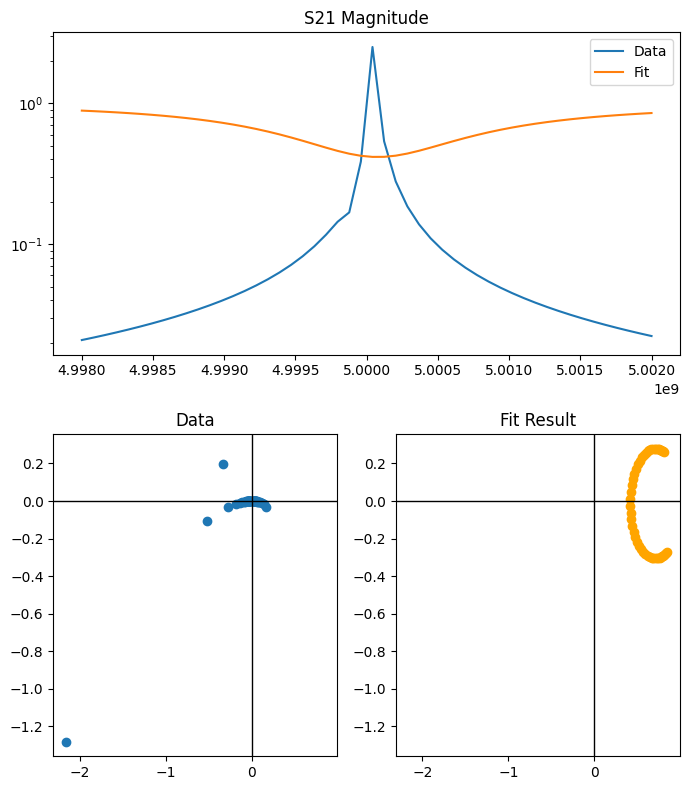

In [26]:
y_fit = result.eval(params=fit_result_params, x=freqs)
# y_fit_err = result.eval_uncertainty()
Q_val = fit_result_params["Q"].value
Q_err = fit_result_params["Q"].stderr
dQ = 100 * Q_err/Q_val
print(dQ, Q_val, Q_err)

print("\nabs(data): ", np.abs(cmplx))
print("abs(result): ", np.abs(y_fit))

##########################################
#############    plotting   ##############
##########################################

mosaic = "AAAA\n BBCC"
fig, axes = plt.subplot_mosaic(mosaic, figsize=(7,8))
ax1, ax2, ax3 = axes["A"], axes["B"], axes["C"]
ax2.sharex(ax3)
ax2.sharey(ax3)

ax1.plot(freqs, np.abs(cmplx), label="Data")
ax1.plot(freqs, np.abs(y_fit), label="Fit")
ax1.set_yscale("log")
ax1.legend()
ax1.set_title("S21 Magnitude")

ax2.plot(np.real(cmplx), np.imag(cmplx), label="Data", linestyle='', marker='o')
ax2.set_title("Data")

ax2.axhline(y=0, color='black', linewidth=1)
ax2.axvline(x=0, color='black', linewidth=1)

ax3.plot(np.real(y_fit), np.imag(y_fit), label="Fit", linestyle='', marker='o', color='orange')
ax3.set_title("Fit Result")

ax3.axhline(y=0, color='black', linewidth=1)
ax3.axvline(x=0, color='black', linewidth=1)


fig.tight_layout()